
# Periodic Star Modulation Fit

This metric was written by Nina Hernitschek (nina.hernitschek@vanderbilt.edu) to evaluate the feasibility of recovering light-curve modulation in RR Lyrae stars, such as caused by the Blazhko effect.  
While the primary purpose is studying the detection of the Blazhko effect, this metric not solely aims at that purpose, but at evaluating variable star light curves from short time intervals in general. 

Original notebook here: https://github.com/ninahernitschek/LSST_cadencenote/blob/main/periodicStarModulationFit_RRLyrae_halo.ipynb 
by Nina Hernitschek ((nina.hernitschek@vanderbilt.edu), 



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import pandas as pd

import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [2]:
# Baseline Survey
baseline_file = get_baseline()
opsdb = maf.db.OpsimDatabase(baseline_file)
runName = os.path.split(baseline_file)[-1].replace('.db', '')

print(runName)

baseline_nexp2_v1.7_10yrs


In [3]:
# Set up output
outDir = 'rrLyrae'
resultsDb = maf.db.ResultsDb(outDir=outDir)

The magnitudes and amplitudes for RR Lyrae in this metric evaluation are set to 0.3 (days) and 0.3 (magnitudes), however we will evaluate two different populations with different colors. 

In [4]:
#Typical periods and amplitude for type c RR Lyrae
#RP_RRc = {0.3,0.32,0.35}
#RA_RRc = {0.3,0.3,0.27}
#compute absolute magnitudes in ugrizy of RRc from OGLE observations in Magellanic Clouds 
#(and we assume 18.5 and 0.08 for the distance modulus and reddening of LMC ).

# colors for c type RRLyrae
I_rrc_lmc = 18.9
V_rrc_lmc = 19.2
Vi = V_rrc_lmc - (2.742 * 0.08) - 18.5   
Ii = I_rrc_lmc - (1.505 * 0.08) - 18.5

ii_rrc = Ii + 0.386*0.013 + 0.397  # 0.013 = (i-z)_0
gi_rrc = ii_rrc+ 1.481*(Vi-Ii) - 0.536
ri_rrc = (1/0.565) * (Vi-0.435*gi_rrc + 0.016)
ui_rrc = gi_rrc + 0.575
zi_rrc = ii_rrc - 0.013
yi_rrc = zi_rrc

#Recovery of RRa
I_RRab_lmc = 18.9
V_RRab_lmc = 19.4

Vi = V_RRab_lmc - (2.742 * 0.08) - 18.5   
Ii = I_RRab_lmc - (1.505 * 0.08) - 18.5

ii_rrab = Ii + 0.386*0.013 + 0.397  # 0.013 = (i-z)_0
gi_rrab = Ii+ 1.481*(Vi-Ii) - 0.536
ri_rrab = (1/0.565) * (Vi-0.435*gi_rrab + 0.016)
ui_rrab = ri_rrab + 0.575
zi_rrab = Ii - 0.013
yi_rrab = zi_rrab

dm = 18.5

rrc = np.array([ui_rrc, gi_rrc, ri_rrc, ii_rrc, zi_rrc, yi_rrc])
rrab = np.array([ui_rrab, gi_rrab, ri_rrab, ii_rrab, zi_rrab, yi_rrab])
print(rrc+dm)
print(rrab+dm)

[19.51835824 18.94335824 19.03766224 19.181618   19.168618   19.168618  ]
[20.04811504 18.83754024 19.47311504 19.181618   18.7666     18.7666    ]


In [5]:
#  Set up to time it at one point in the sky

time_interval = 20
dM = 19.0
summaryStats = [maf.MeanMetric(), maf.MedianMetric(), maf.MaxMetric()]

metricC = maf.PeriodicStarModulationMetric(period=0.3, amplitude=0.3, random_phase=True,
                                          time_interval=time_interval,
                                          nMonte=100, periodTol=0.002, ampTol=0.01, 
                                          means=rrc+dM,
                                          magTol=0.01, nBands=3)
slicer = maf.HealpixSlicer(nside=8)
sql = 'night < 365*2'

bundleC = maf.MetricBundle(metricC, slicer, sql, 
                                    runName=runName, summaryMetrics=summaryStats,
                                    metadata=f'dm {dM} interval {time_interval} RRc')

bg =  maf.MetricBundleGroup({'RRc': bundleC}, opsdb,
                             outDir=outDir, resultsDb=resultsDb)

# Behind the scenes stuff to get the simulated data and set up the slicer so we can test ONE point
bg.setCurrent(sql)
bg.getData(sql)
simData = bg.simData
bundleC.slicer.setupSlicer(simData)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits


In [6]:
lenvisits = []
for s in bundleC.slicer:
    lenvisits.append(len(s['idxs']))
lenvisits = np.array(lenvisits)
x = np.where(lenvisits == np.max(lenvisits))[0][0]

bundleC.slicer[x]

{'idxs': array([396671, 396646, 396647, ..., 261839, 185708,  55903]),
 'slicePoint': {'sid': 660,
  'ra': 1.009797638653862,
  'dec': -0.8402225818983444,
  'nside': 8}}

In [7]:
%%timeit 

metricC.run(simData[bundleC.slicer[x]['idxs']], bundleC.slicer[x]['slicePoint'])

4.07 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# Set a variety of time intervals - the short periods in which to evaluate each light curve
# and distance moduli, to vary the input magnitudes to be equivalent to different distances.


time_intervals = (15, 20, 30, 50) 
# Looking at cadence note output, suggests that 50 days may not show much difference with varying survey strategy
distMod = (17.0, 18.0, 19.0, 20.0, 21.0, 22.0) 
# And perhaps could drop 17 and 22 as these don't show as much variation as the in-betwen values either

time_intervals = (15, 20, 30)
distMod = (18, 19, 20,  21)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
7.680000000000001 hours to run metric (best-guess)


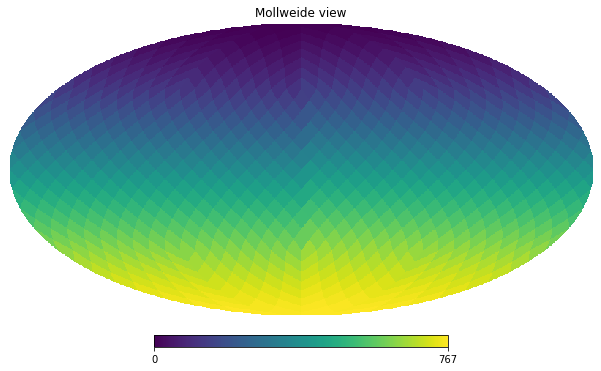

In [9]:
# And likely could refine the slice point positions - maybe (there are 768 points on the sky)
# (note that using galL/galB doesn't change the position of the healpix grid points on the sky)

slicer = maf.HealpixSlicer(nside=8)
hp.mollview(slicer.slicePoints['sid'])

print(len(slicer) * len(time_intervals) * len(distMod) * 6/60/60/2, 'hours to run metric (best-guess)')

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/plots/spatialPlotters.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(fignum, figsize=plotDict['figsize'])
0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365*2 for columns ['fiveSigmaDepth', 'fieldRA', 'observationStartMJD', 'rotSkyPos', 'filter', 'fieldDec']
Found 396785 visits
Running:  ['RRc', 'RRab']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365*2" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.


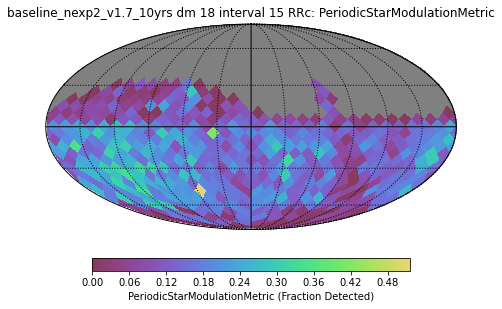

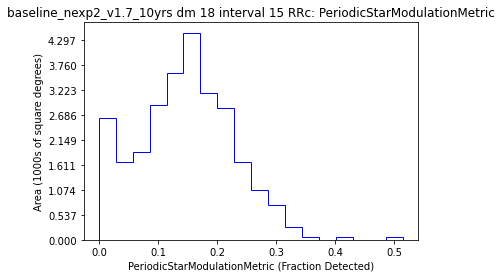

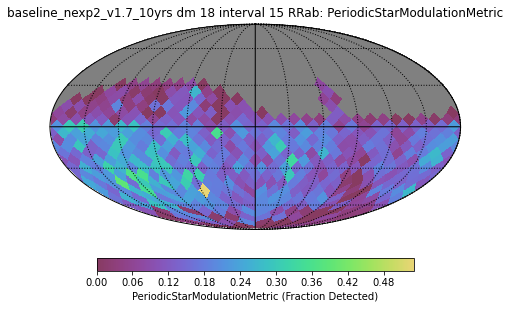

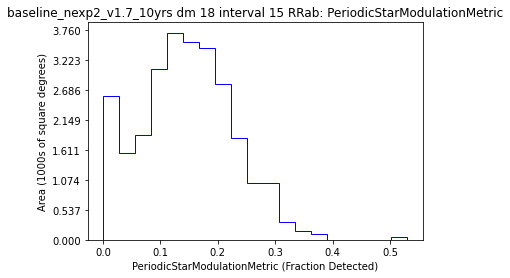

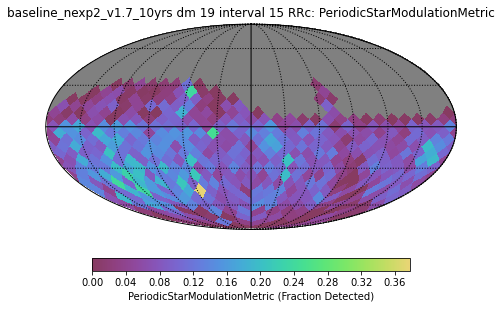

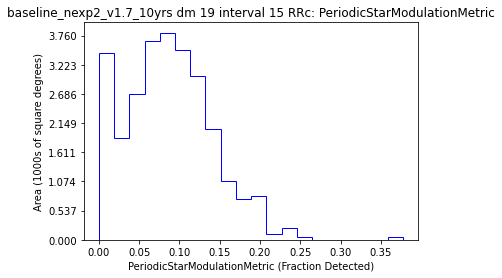

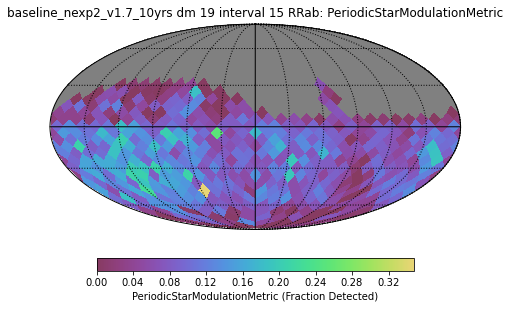

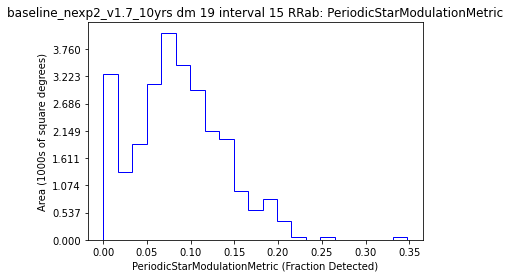

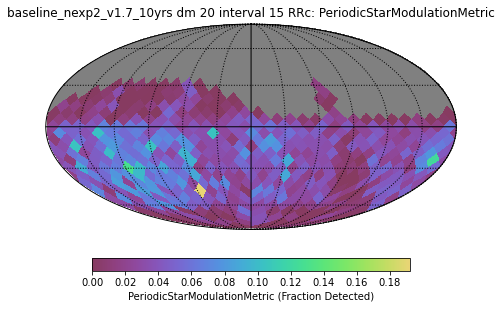

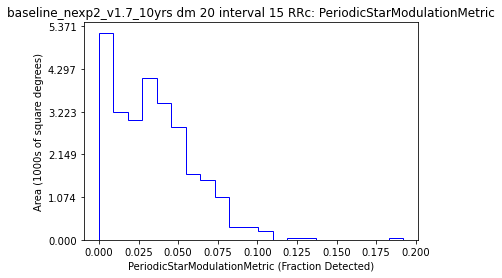

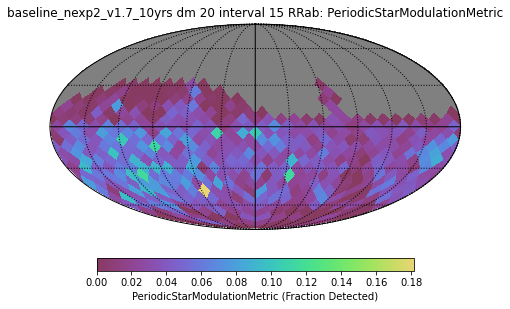

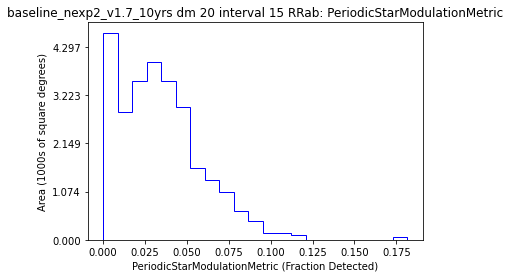

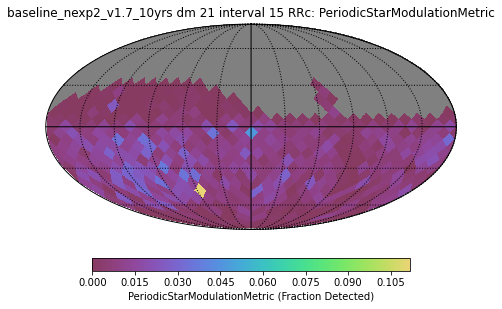

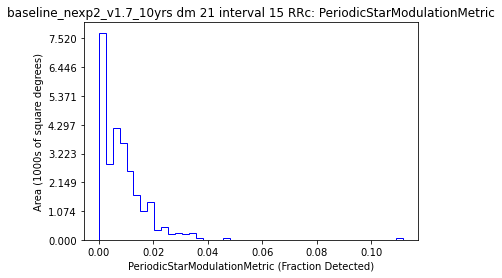

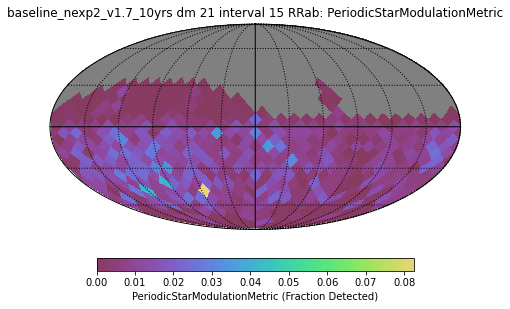

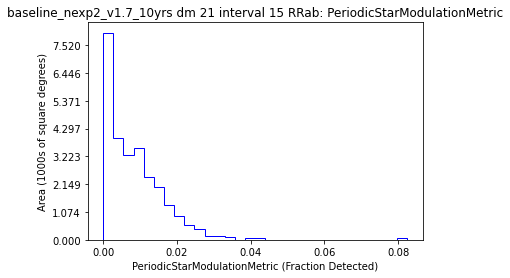

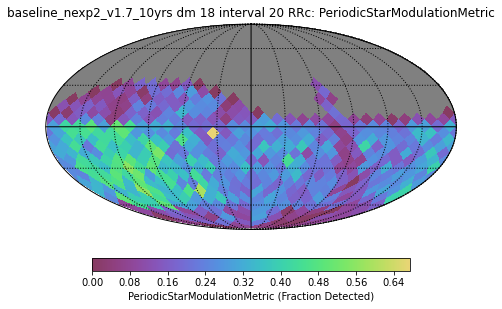

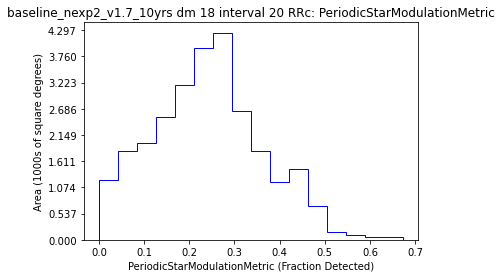

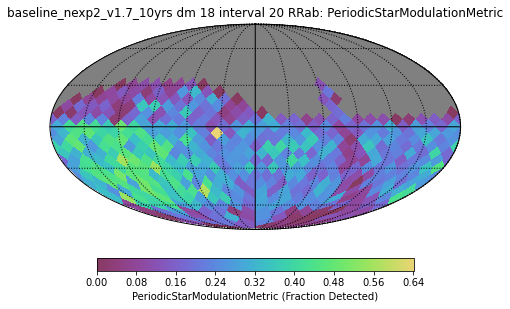

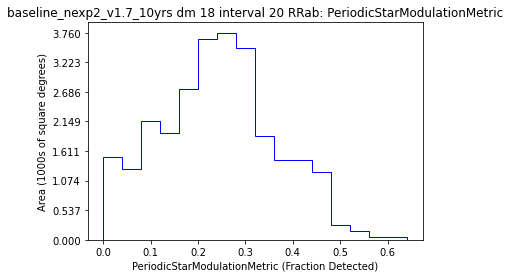

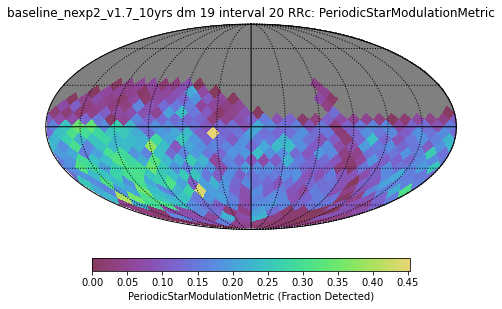

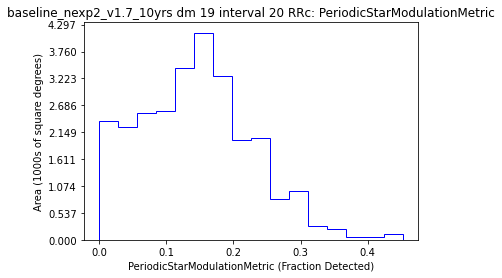

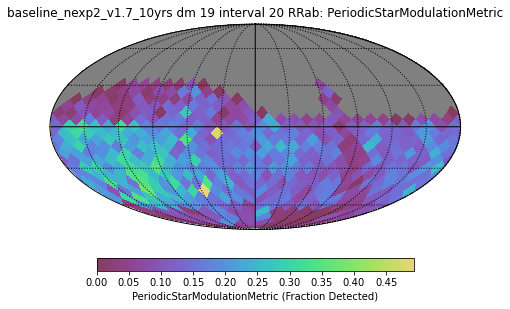

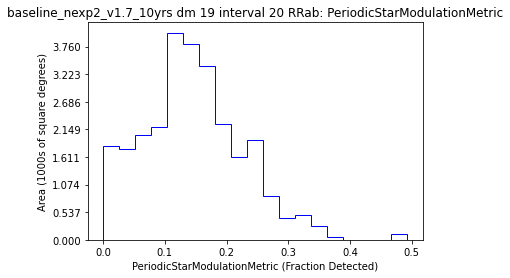

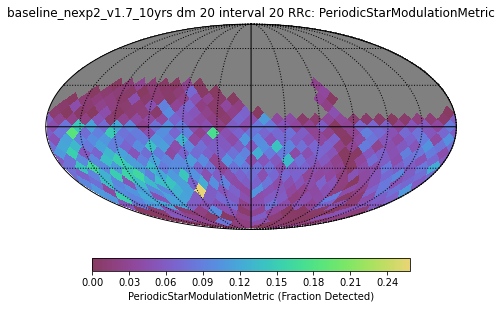

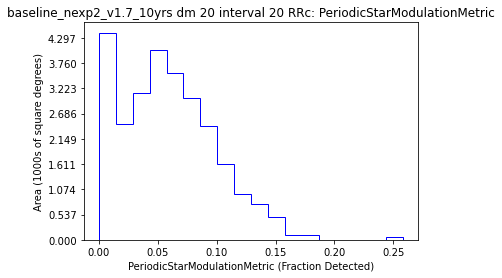

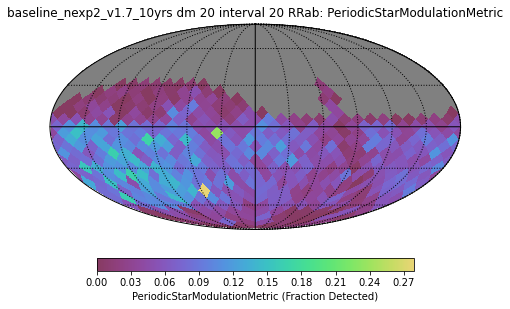

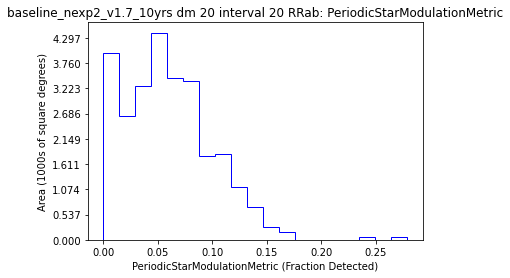

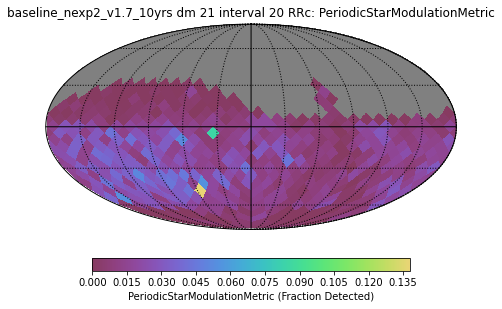

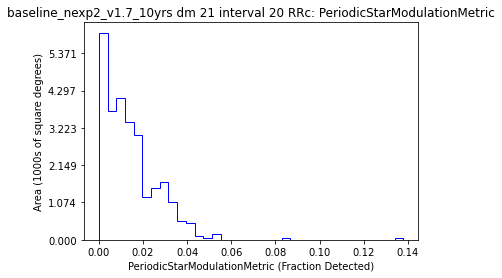

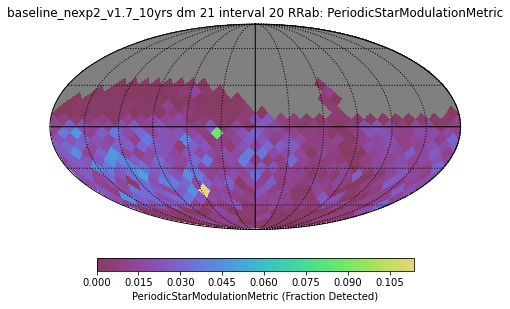

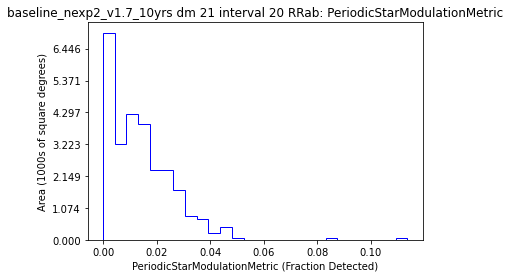

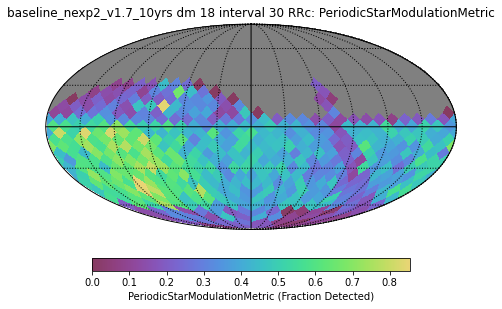

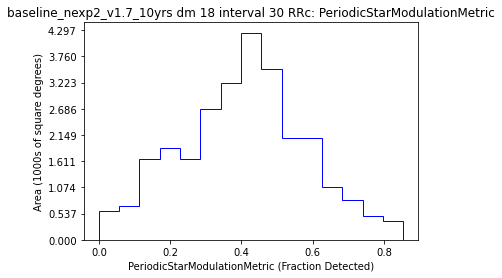

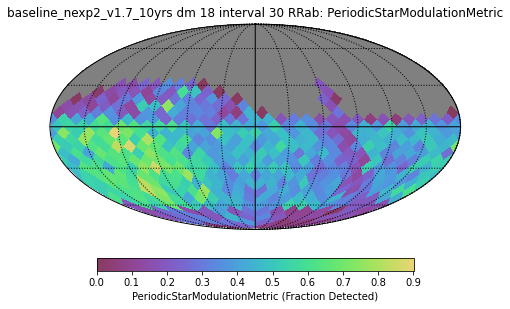

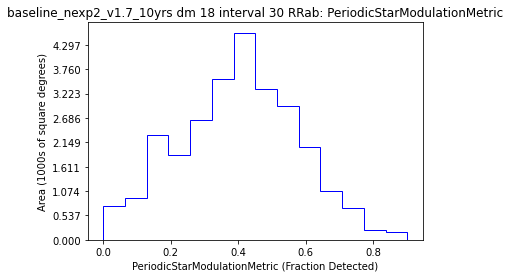

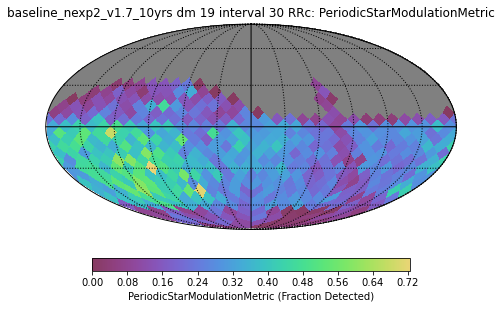

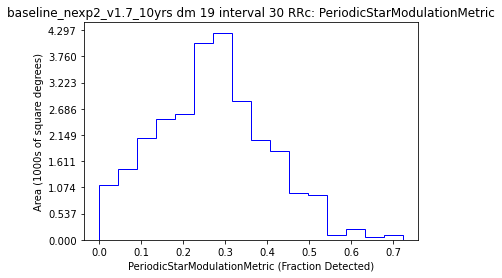

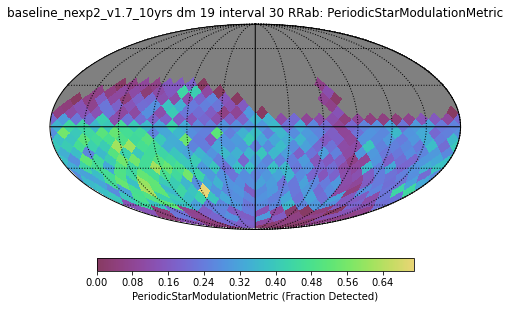

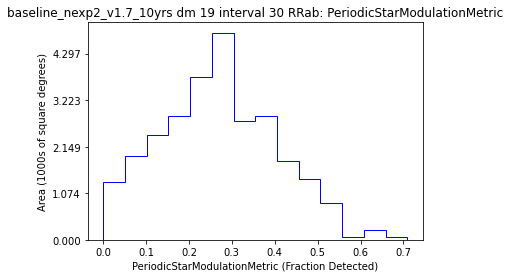

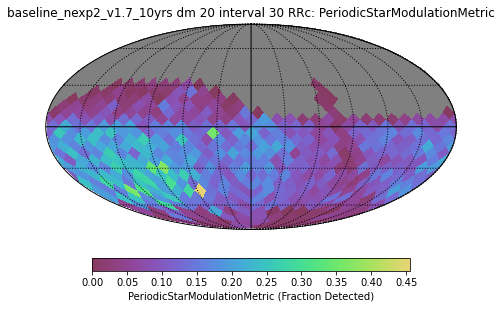

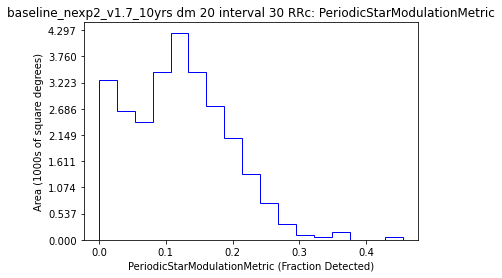

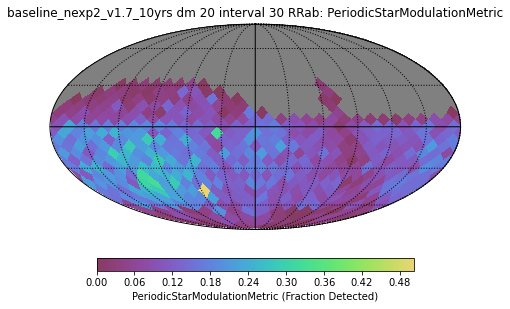

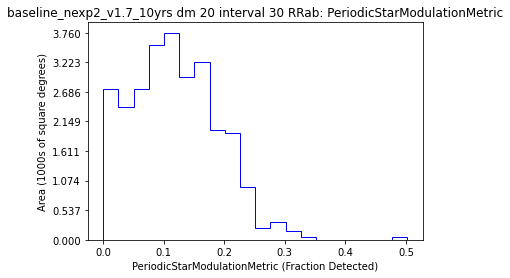

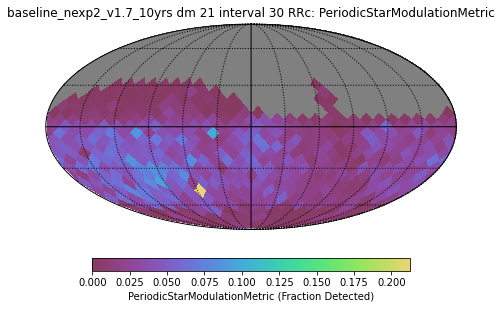

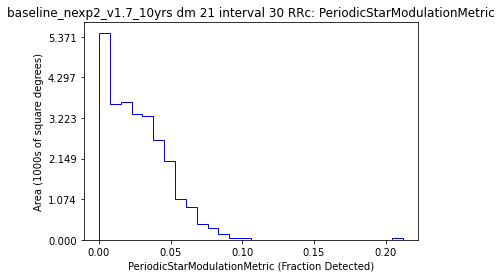

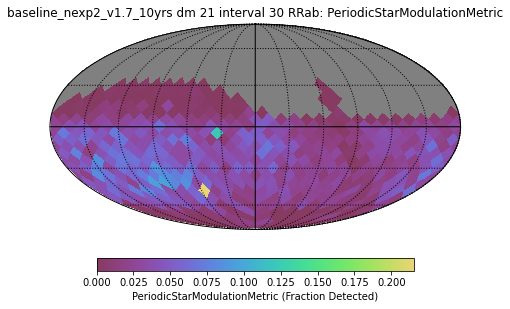

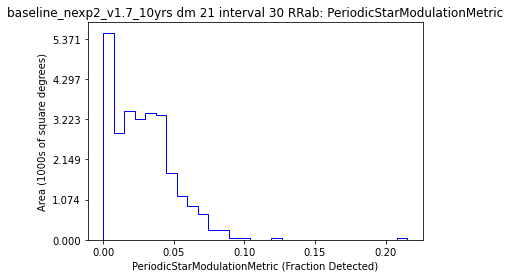

In [10]:
summaryStats = [maf.MeanMetric(), maf.MedianMetric(), maf.MaxMetric()]

for time_interval in time_intervals:
    for dM in distMod:

        metricC = maf.PeriodicStarModulationMetric(period=0.3, amplitude=0.3, random_phase=True,
                                                  time_interval=time_interval,
                                                  nMonte=100, periodTol=0.002, ampTol=0.01, 
                                                  means=rrc+dM,
                                                  magTol=0.01, nBands=3)
        metricAB = maf.PeriodicStarModulationMetric(period=0.3, amplitude=0.3, random_phase=True,
                                                  time_interval=time_interval,
                                                  nMonte=100, periodTol=0.002, ampTol=0.01, 
                                                  means=rrab+dM,
                                                  magTol=0.01, nBands=3)    
        slicer = maf.HealpixSlicer(nside=8)
        sql = 'night < 365*2'

        bundleC = maf.MetricBundle(metricC, slicer, sql, 
                                            runName=runName, summaryMetrics=summaryStats,
                                            metadata=f'dm {dM} interval {time_interval} RRc')
        bundleAB = maf.MetricBundle(metricC, slicer, sql, 
                                            runName=runName, summaryMetrics=summaryStats,
                                            metadata=f'dm {dM} interval {time_interval} RRab')
        bg =  maf.MetricBundleGroup({'RRc': bundleC, 'RRab': bundleAB}, opsdb,
                                              outDir=outDir, resultsDb=resultsDb)    
        bg.runAll()        
        bg.plotAll(closefigs=False)

In [24]:
# Whoops .. over-wrote the bundle when I ran that above. 
# So let's read them back from disk.
bundlesAB = {}
bundlesC = {}
for t in time_intervals:
    bundlesAB[t] = {}
    bundlesC[t] = {}
    for dm in distMod:
        filename = os.path.join(outDir, f"{runName.replace('.', '_')}_PeriodicStarModulationMetric_dm_{dm}_interval_{t}_RRab_HEAL.npz")
        bundlesAB[t][dm] = maf.MetricBundle.load(filename)
        filename = os.path.join(outDir, f"{runName.replace('.', '_')}_PeriodicStarModulationMetric_dm_{dm}_interval_{t}_RRc_HEAL.npz")
        bundlesC[t][dm] = maf.MetricBundle.load(filename)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSID

In [40]:
# What are some useful metrics? 
summaryMetrics = [maf.MeanMetric(), maf.MedianMetric(), maf.MaxMetric(), maf.AreaThresholdMetric(lower_threshold=0.1)]


for t in time_intervals:
    for dM in distMod:
        bundlesAB[t][dM].setSummaryMetrics(summaryMetrics)
        bundlesAB[t][dM].computeSummaryStats(resultsDb)
        bundlesC[t][dM].setSummaryMetrics(summaryMetrics)
        bundlesC[t][dM].computeSummaryStats(resultsDb)

In [47]:
# Easiest way to get these back out is from the resultsDb
# Pull them out for the RRc first
mIds = resultsDb.getMetricIdLike(metricMetadataLike='RRC')
stats = resultsDb.getSummaryStats(mIds)

In [50]:
d = pd.DataFrame(stats)
d[['summaryName', 'metricMetadata', 'summaryMetric', 'summaryValue']]

,summaryName,metricMetadata,summaryMetric,summaryValue
0,Mean PeriodicStarModulationMetric dm 18 interv...,dm 18 interval 15 RRc,Mean,0.147010
1,Median PeriodicStarModulationMetric dm 18 inte...,dm 18 interval 15 RRc,Median,0.149773
2,Max PeriodicStarModulationMetric dm 18 interva...,dm 18 interval 15 RRc,Max,0.515833
3,AreaThreshold PeriodicStarModulationMetric dm ...,dm 18 interval 15 RRc,AreaThreshold,19337.325586
4,Mean PeriodicStarModulationMetric dm 19 interv...,dm 19 interval 15 RRc,Mean,0.086300
5,Median PeriodicStarModulationMetric dm 19 inte...,dm 19 interval 15 RRc,Median,0.084045
6,Max PeriodicStarModulationMetric dm 19 interva...,dm 19 interval 15 RRc,Max,0.377917
7,AreaThreshold PeriodicStarModulationMetric dm ...,dm 19 interval 15 RRc,AreaThreshold,10098.381139
8,Mean PeriodicStarModulationMetric dm 20 interv...,dm 20 interval 15 RRc,Mean,0.034518
9,Median PeriodicStarModulationMetric dm 20 inte...,dm 20 interval 15 RRc,Median,0.032950


Text(0.5, 1.0, 'Area on sky with >10% recovered')

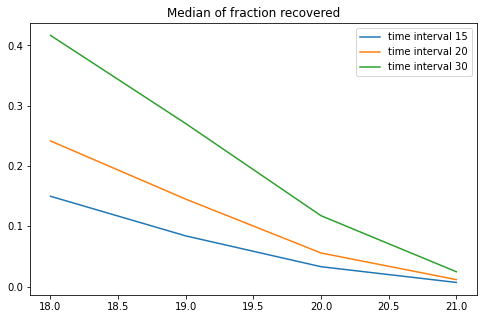

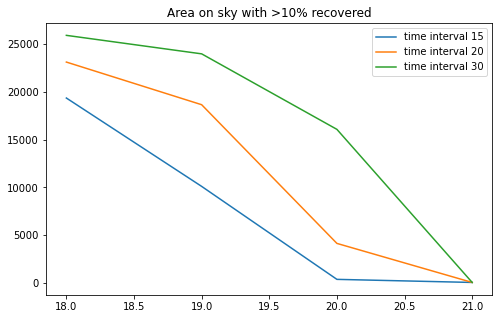

In [60]:
# Pull these apart for intervals / distance moduli and plot
# Oh .. maybe easiest to let the resultsDb do the lifting here
d = {}
plt.figure(figsize=(8,5))
for t in time_intervals:
    mIds = resultsDb.getMetricIdLike(metricMetadataLike=f'interval {t} RRC')
    stats = resultsDb.getSummaryStats(mIds, summaryName='Median')
    d[t] = stats
    plt.plot(distMod, d[t]['summaryValue'], label=f"time interval {t}")
plt.legend()
plt.title("Median of fraction recovered")

d = {}
plt.figure(figsize=(8,5))
for t in time_intervals:
    mIds = resultsDb.getMetricIdLike(metricMetadataLike=f'interval {t} RRC')
    stats = resultsDb.getSummaryStats(mIds, summaryNameLike='Area')
    d[t] = stats
    plt.plot(distMod, d[t]['summaryValue'], label=f"time interval {t}")
plt.legend()
plt.title("Area on sky with >10% recovered")